In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Loss function

## cross entropy function

In [2]:
def cross_entropy(Y, Y_pred):
    # Cộng thêm 1e-9 để tránh log(0)
    loss = np.asarray([np.sum(np.multiply(Y[i], np.log(Y_pred[i] + 1e-9))) for i in range(Y.shape[0])])
    return -np.mean(loss)

In [3]:
Y = np.array([[1, 0, 0], [0, 0, 1]])
Y_pred = np.array([[1, 0, 0], [0, 0, 1]])
cross_entropy(Y, Y_pred)

-1.000000082240371e-09

## Class layer

In [4]:
class Input_Layer:
    def __init__(self, X, Y, output_size):
        self.X = X
        self.Y = Y

        self.output_size = output_size

In [5]:
class Dense_Layer:
    def __init__(self, input_size=None, output_size=None):
        self.input_size = input_size
        self.output_size = output_size
        self.W = None
        self.B = None

    def forward_propagation(self, inputs):
        self.inputs = inputs
        self.outputs = np.dot(inputs, self.W) + self.B

    def back_propagation(self, E):
        self.dW = np.dot(self.inputs.T, E)
        self.dB = np.sum(E, axis=0, keepdims=True)
        
        self.dInputs = np.dot(E, self.W.T)

In [6]:
class Activation_Layer:
    def __init__(self, activation=None):
        self.activation = activation
        self.input_size = None
        self.output_size = None

    def forward_propagation(self, inputs):
        self.inputs = inputs

        if self.activation == 'relu':
            self.outputs = np.maximum(0, inputs)
        elif self.activation == 'softmax':
            exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                                keepdims=True))
            # Normalize them for each sample
            probabilities = exp_values / np.sum(exp_values, axis=1,
                                                keepdims=True)

            self.outputs = probabilities

    def back_propagation(self, E):
        if self.activation == 'relu':
            self.dInputs = E.copy()
            self.dInputs[self.inputs <= 0] = 0
        elif self.activation == 'softmax':
            self.dInputs = np.empty_like(E)
                # Enumerate outputs and gradients
            for index, (single_output, single_dvalues) in enumerate(zip(self.outputs, E)):
                # Flatten output array
                single_output = single_output.reshape(-1, 1)
                # Calculate Jacobian matrix of the output
                jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

                # Calculate sample-wise gradient
                # and add it to the array of sample gradients
                self.dInputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [7]:
class NeuralNetwork:
    def __init__(self, *args):
        self.numLayers = len(args)
        self.layers = []

        for layer in args:
            self.layers.append(layer)
            if len(self.layers) > 1:
                if type(self.layers[-1]).__name__ == 'Dense_Layer':
                    self.layers[-1].input_size = self.layers[-2].output_size
                elif type(self.layers[-1]).__name__ == 'Activation_Layer':
                    self.layers[-1].input_size = self.layers[-2].input_size
                    self.layers[-1].output_size = self.layers[-2].output_size

    
    def forward_propagation(self, X):
        for i in range(1, self.numLayers):
            if i == 1:
                self.layers[i].forward_propagation(X)
            else:
                self.layers[i].forward_propagation(self.layers[i-1].outputs)

    def compute_loss(self, Y, Y_pred):
        if self.loss == 'cross_entropy':
            return cross_entropy(Y, Y_pred)

    def back_propagation(self, Y):
        if self.loss == 'cross_entropy':
            self.layers[-1].dInputs = (self.layers[-1].outputs - Y) / (self.layers[-1].outputs.shape[0])

        for i in range(-2, -self.numLayers, -1):
            self.layers[i].back_propagation(self.layers[i+1].dInputs)

    def update_weights(self, lr):
        for i in range(1, self.numLayers):
            if type(self.layers[i]).__name__ == 'Dense_Layer':
                self.layers[i].W -= lr * self.layers[i].dW
                self.layers[i].B -= lr * self.layers[i].dB

    def predict(self, X):
        self.forward_propagation(X)
        return self.layers[-1].outputs

    def evaluate(self, Y, Y_pred):
        pred = np.asarray([Y_pred[i].argmax() for i in range(len(Y_pred))])
        truth = np.asarray([Y[i].argmax() for i in range(len(Y))])
        return np.mean(pred == truth)

    def compile(self, lr=None, loss=None, seed=None):
        self.lr = lr
        self.loss = loss
        self.seed = seed

        np.random.seed(seed)
        random.seed(seed)

        for i in range(1, self.numLayers):
            # print(self.layers[i].input_size, self.layers[i].output_size)
            if type(self.layers[i]).__name__ == 'Dense_Layer':
                self.layers[i].W = np.random.randn(self.layers[i].input_size, self.layers[i].output_size) / np.sqrt(self.layers[i].input_size * self.layers[i].output_size)
                self.layers[i].B = np.zeros((1, self.layers[i].output_size))

    def lr_exp_decay(self, epoch):
        decay = 0.1
        return self.lr * math.exp(-decay * epoch)

    def fit(self, epochs, batch_size=None):
        X = self.layers[0].X
        Y = self.layers[0].Y

        if batch_size == None:
            batch_size = X.shape[0]

        batches = math.ceil(X.shape[0] / batch_size)

        loss_array = []
        acc_array = []

        for epoch in range(epochs):
            loss_accumulated = 0
            acc_accumulated = 0

            for batch in range(batches):
                batch_X = X[batch_size*batch:min(batch_size*(batch+1), X.shape[0])]
                batch_Y = Y[batch_size*batch:min(batch_size*(batch+1), X.shape[0])]

                self.forward_propagation(batch_X)
                self.back_propagation(batch_Y)
                self.update_weights(self.lr_exp_decay(epoch))

                loss_score = self.compute_loss(batch_Y, self.layers[-1].outputs)

                Y_pred = self.predict(batch_X)
                acc = self.evaluate(batch_Y, Y_pred)

                loss_accumulated += loss_score
                acc_accumulated += acc

            loss_accumulated /= batches
            acc_accumulated /= batches

            loss_array.append(loss_accumulated)
            acc_array.append(acc_accumulated)
            
            print(f'Epoch {epoch+1}/{epochs}: loss: {loss_accumulated} - acc: {acc_accumulated}')
            
        return [acc_array, loss_array]

# Load dữ liệu

In [8]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

def to_one_hot(labels, dimension):
    result = np.zeros((len(labels), dimension), dtype = np.uint8)
    for i, label in enumerate(labels):
        result[i, label] = 1
    return np.asarray(result)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))

# Normalize
train_X = (train_X / 255).astype(np.float64)
test_X = (test_X / 255).astype(np.float64)
train_size = train_X.shape[0]
test_size = test_X.shape[0]

# Flatten data
trainX = np.asarray([train_X[i].flatten() for i in range(train_size)])
testX = np.asarray([test_X[i].flatten() for i in range(test_size)])

# Encode label to one hot
trainY = to_one_hot(train_y, 10)
testY = to_one_hot(test_y, 10)
print(trainY.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
(60000, 10)


# Taọ model

In [9]:
model = NeuralNetwork(Input_Layer(trainX, trainY, output_size=28*28),
                      
                      Dense_Layer(output_size=512),
                      Activation_Layer('relu'),

                      Dense_Layer(output_size=10),
                      Activation_Layer('softmax'))

model.compile(lr=0.5, loss='cross_entropy', seed=123)
history = model.fit(epochs=20, batch_size=128)

Epoch 1/20: loss: 0.35649148944028225 - acc: 0.9318974324804549
Epoch 2/20: loss: 0.1353297279220058 - acc: 0.9833533226723525
Epoch 3/20: loss: 0.09393587569771557 - acc: 0.9904828535891969
Epoch 4/20: loss: 0.07246686555355894 - acc: 0.9935478855721392
Epoch 5/20: loss: 0.058655681983694904 - acc: 0.9951636904761905
Epoch 6/20: loss: 0.049138527661515274 - acc: 0.9962131307746979
Epoch 7/20: loss: 0.04215472440348173 - acc: 0.9969793887704335
Epoch 8/20: loss: 0.03680775787622174 - acc: 0.9973958333333333
Epoch 9/20: loss: 0.03263999198612085 - acc: 0.9976790156361052
Epoch 10/20: loss: 0.02933364717142687 - acc: 0.997928882373845
Epoch 11/20: loss: 0.02663046768556808 - acc: 0.9981454335465529
Epoch 12/20: loss: 0.02444646914832522 - acc: 0.9983286691542288
Epoch 13/20: loss: 0.022657869389633555 - acc: 0.9984952469793887
Epoch 14/20: loss: 0.021161340968024276 - acc: 0.9985785358919687
Epoch 15/20: loss: 0.019911080520063126 - acc: 0.9986451670220327
Epoch 16/20: loss: 0.0188601406

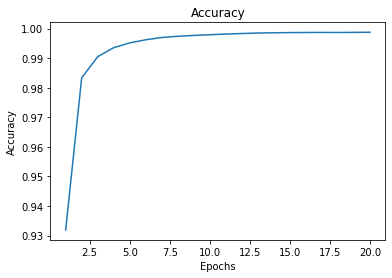

In [10]:
epoch_axis = list(range(1, 21))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(epoch_axis, history[0])

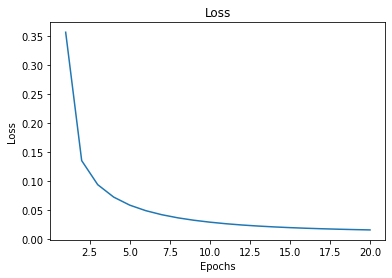

In [11]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(epoch_axis, history[1])

In [12]:
model.evaluate(model.predict(testX), testY)

0.9817